In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from scipy.cluster.hierarchy import dendrogram

import re
import string
import time
from PIL import Image
from collections import Counter

import plotly.express as px

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words as nltk_words
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir='./resources')
nltk.download('punkt', download_dir='./resources')
nltk.download('wordnet', download_dir='./resources')
nltk.download('omw-1.4', download_dir='./resources')
nltk.download('words', download_dir='./resources')
nltk.data.path.append('./resources')

[nltk_data] Downloading package stopwords to ./resources...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./resources...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to ./resources...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./resources...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to ./resources...
[nltk_data]   Package words is already up-to-date!


# Exploratory Data Analysis

In [2]:
data = pd.read_csv('bbc_news.csv')
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
35855,Bell leads England to ODI clean sweep over New...,"Wed, 03 Jul 2024 20:08:56 GMT",https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...
35856,Murrays and all-British battles headline day four,"Wed, 03 Jul 2024 21:22:45 GMT",https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...
35857,Highlights: Raducanu dominant in win over Mertens,"Wed, 03 Jul 2024 17:40:34 GMT",https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...
35858,Chasing the 'Ghost' - a superstar struck down ...,"Wed, 03 Jul 2024 23:03:58 GMT",https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35860 entries, 0 to 35859
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        35860 non-null  object
 1   pubDate      35860 non-null  object
 2   guid         35860 non-null  object
 3   link         35860 non-null  object
 4   description  35860 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [4]:
data.describe()

,title,pubDate,guid,link,description
count,35860,35860,35860,35860,35860
unique,33889,34470,33081,32335,33124
top,Election poll tracker: How do the parties comp...,"Tue, 13 Jun 2023 10:25:22 GMT",https://www.bbc.co.uk/news/business-61634959,https://www.bbc.co.uk/news/business-61634959?a...,How closely have you been paying attention to ...
freq,34,9,63,61,80


In [5]:
data['pubDate'] = pd.to_datetime(data['pubDate'], infer_datetime_format=True)
data

C:\Users\saxen\AppData\Local\Temp\ipykernel_16208\3164531547.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['pubDate'] = pd.to_datetime(data['pubDate'], infer_datetime_format=True)


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
35855,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...
35856,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...
35857,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...
35858,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...


## Remove duplicates

In [6]:
data = data.drop_duplicates(subset=['title']).drop_duplicates(subset=['guid']).drop_duplicates(subset=['description']).reset_index(drop=True)
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...


In [7]:
STOPWORDS = stopwords.words('english')
pd.Series(STOPWORDS)

0             i
1            me
2            my
3        myself
4            we
         ...   
174     weren't
175         won
176       won't
177      wouldn
178    wouldn't
Length: 179, dtype: object

## Remove stopwords and count frequencies for single words

In [8]:
sns.set_style('darkgrid')

In [9]:
data['combined'] = data['title'] + ' ' + data['description']
data['combined']

0        Ukraine: Angry Zelensky vows to punish Russian...
1        War in Ukraine: Taking cover in a town under a...
2        Ukraine war 'catastrophic for global food' One...
3        Manchester Arena bombing: Saffie Roussos's par...
4        Ukraine conflict: Oil price soars to highest l...
                               ...                        
32053    Bell leads England to ODI clean sweep over New...
32054    Murrays and all-British battles headline day f...
32055    Highlights: Raducanu dominant in win over Mert...
32056    Chasing the 'Ghost' - a superstar struck down ...
32057    Le Pen's far-right at the gates of power The N...
Name: combined, Length: 32058, dtype: object

In [10]:
top_N = 50
a = data['combined'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.cat(sep=' ')
words = list(filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(a)))
word_dist = nltk.FreqDist(words)
freq_title = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
freq_title

,Word,Frequency
0,says,5300
1,world,3186
2,england,2709
3,cup,2664
4,new,2490
5,first,2111
6,ukraine,1958
7,uk,1928
8,bbc,1926
9,us,1918


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'says'),
  Text(1, 0, 'world'),
  Text(2, 0, 'england'),
  Text(3, 0, 'cup'),
  Text(4, 0, 'new'),
  Text(5, 0, 'first'),
  Text(6, 0, 'ukraine'),
  Text(7, 0, 'uk'),
  Text(8, 0, 'bbc'),
  Text(9, 0, 'us'),
  Text(10, 0, 'win'),
  Text(11, 0, 'league'),
  Text(12, 0, 'people'),
  Text(13, 0, 'say'),
  Text(14, 0, 'war'),
  Text(15, 0, 'police'),
  Text(16, 0, 'years'),
  Text(17, 0, 'two'),
  Text(18, 0, 'one'),
  Text(19, 0, 'city'),
  Text(20, 0, 'man'),
  Text(21, 0, 'manchester'),
  Text(22, 0, 'could'),
  Text(23, 0, 'final'),
  Text(24, 0, 'day'),
  Text(25, 0, 'former'),
  Text(26, 0, '2022'),
  Text(27, 0, 'watch'),
  Text(28, 0, 'home'),
  Text(29, 0, 'papers'),
  Text(30, 0, '

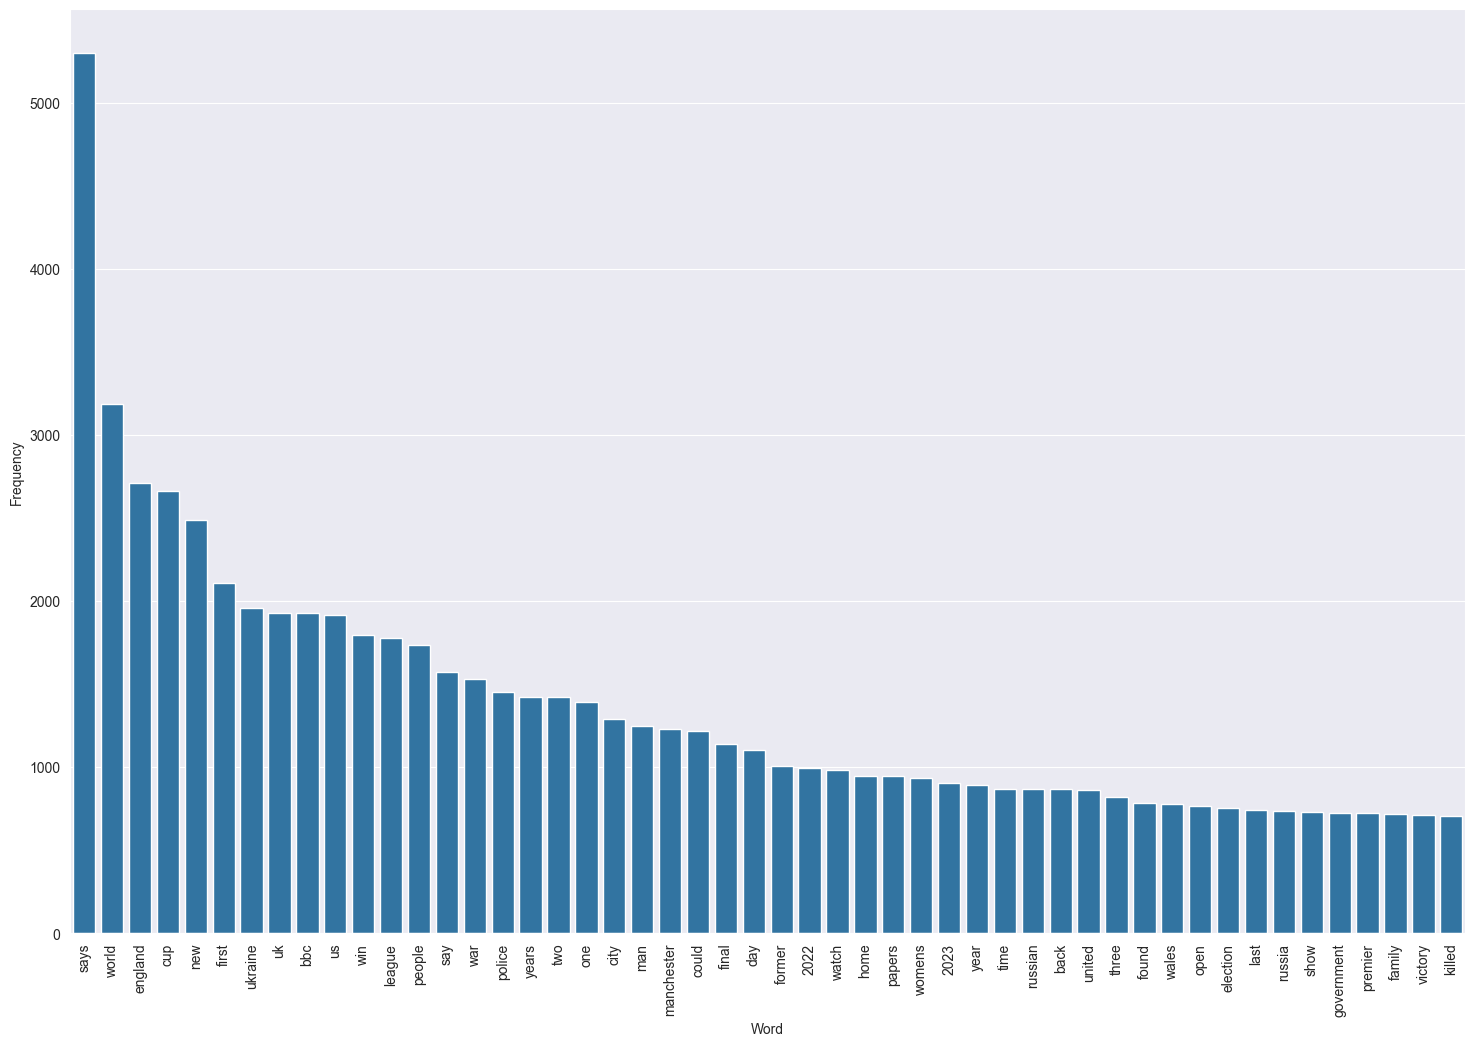

In [16]:
plt.figure(figsize=(18, 12))
sns.barplot(data=freq_title, x='Word', y='Frequency')
plt.xticks(rotation=90)

## Looking for the most popular 2-grams and 3-grams

In [11]:
def find_ngrams(input_list, n):
    return list(zip(*(input_list[i:] for i in range(n))))

In [12]:
bigrams = find_ngrams(words, 2)
bigrams

[('ukraine', 'angry'),
 ('angry', 'zelensky'),
 ('zelensky', 'vows'),
 ('vows', 'punish'),
 ('punish', 'russian'),
 ('russian', 'atrocities'),
 ('atrocities', 'ukrainian'),
 ('ukrainian', 'president'),
 ('president', 'says'),
 ('says', 'country'),
 ('country', 'forgive'),
 ('forgive', 'forget'),
 ('forget', 'murder'),
 ('murder', 'civilians'),
 ('civilians', 'war'),
 ('war', 'ukraine'),
 ('ukraine', 'taking'),
 ('taking', 'cover'),
 ('cover', 'town'),
 ('town', 'attack'),
 ('attack', 'jeremy'),
 ('jeremy', 'bowen'),
 ('bowen', 'frontline'),
 ('frontline', 'irpin'),
 ('irpin', 'residents'),
 ('residents', 'came'),
 ('came', 'russian'),
 ('russian', 'fire'),
 ('fire', 'trying'),
 ('trying', 'flee'),
 ('flee', 'ukraine'),
 ('ukraine', 'war'),
 ('war', 'catastrophic'),
 ('catastrophic', 'global'),
 ('global', 'food'),
 ('food', 'one'),
 ('one', 'worlds'),
 ('worlds', 'biggest'),
 ('biggest', 'fertiliser'),
 ('fertiliser', 'firms'),
 ('firms', 'says'),
 ('says', 'conflict'),
 ('conflict', '

In [13]:
bigrams_dist = nltk.FreqDist(bigrams)
bigram_freq_title = pd.DataFrame(bigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
bigram_freq_title

,N-gram,Frequency
0,"(world, cup)",1916
1,"(ukraine, war)",689
2,"(premier, league)",680
3,"(manchester, united)",496
4,"(manchester, city)",455
5,"(champions, league)",421
6,"(rishi, sunak)",385
7,"(cup, 2022)",324
8,"(fa, cup)",317
9,"(first, time)",296


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'world cup'),
  Text(1, 0, 'ukraine war'),
  Text(2, 0, 'premier league'),
  Text(3, 0, 'manchester united'),
  Text(4, 0, 'manchester city'),
  Text(5, 0, 'champions league'),
  Text(6, 0, 'rishi sunak'),
  Text(7, 0, 'cup 2022'),
  Text(8, 0, 'fa cup'),
  Text(9, 0, 'first time'),
  Text(10, 0, 'womens world'),
  Text(11, 0, 'prime minister'),
  Text(12, 0, 'cost living'),
  Text(13, 0, 'south africa'),
  Text(14, 0, 'social media'),
  Text(15, 0, 'boris johnson'),
  Text(16, 0, 'new zealand'),
  Text(17, 0, 'six nations'),
  Text(18, 0, 'cup final'),
  Text(19, 0, 'dies aged'),
  Text(20, 0, 'king charles'),
  Text(21, 0, 'police say'),
  Text(22, 0, 'bbc sport'),
  Text(23, 0, 'euro 

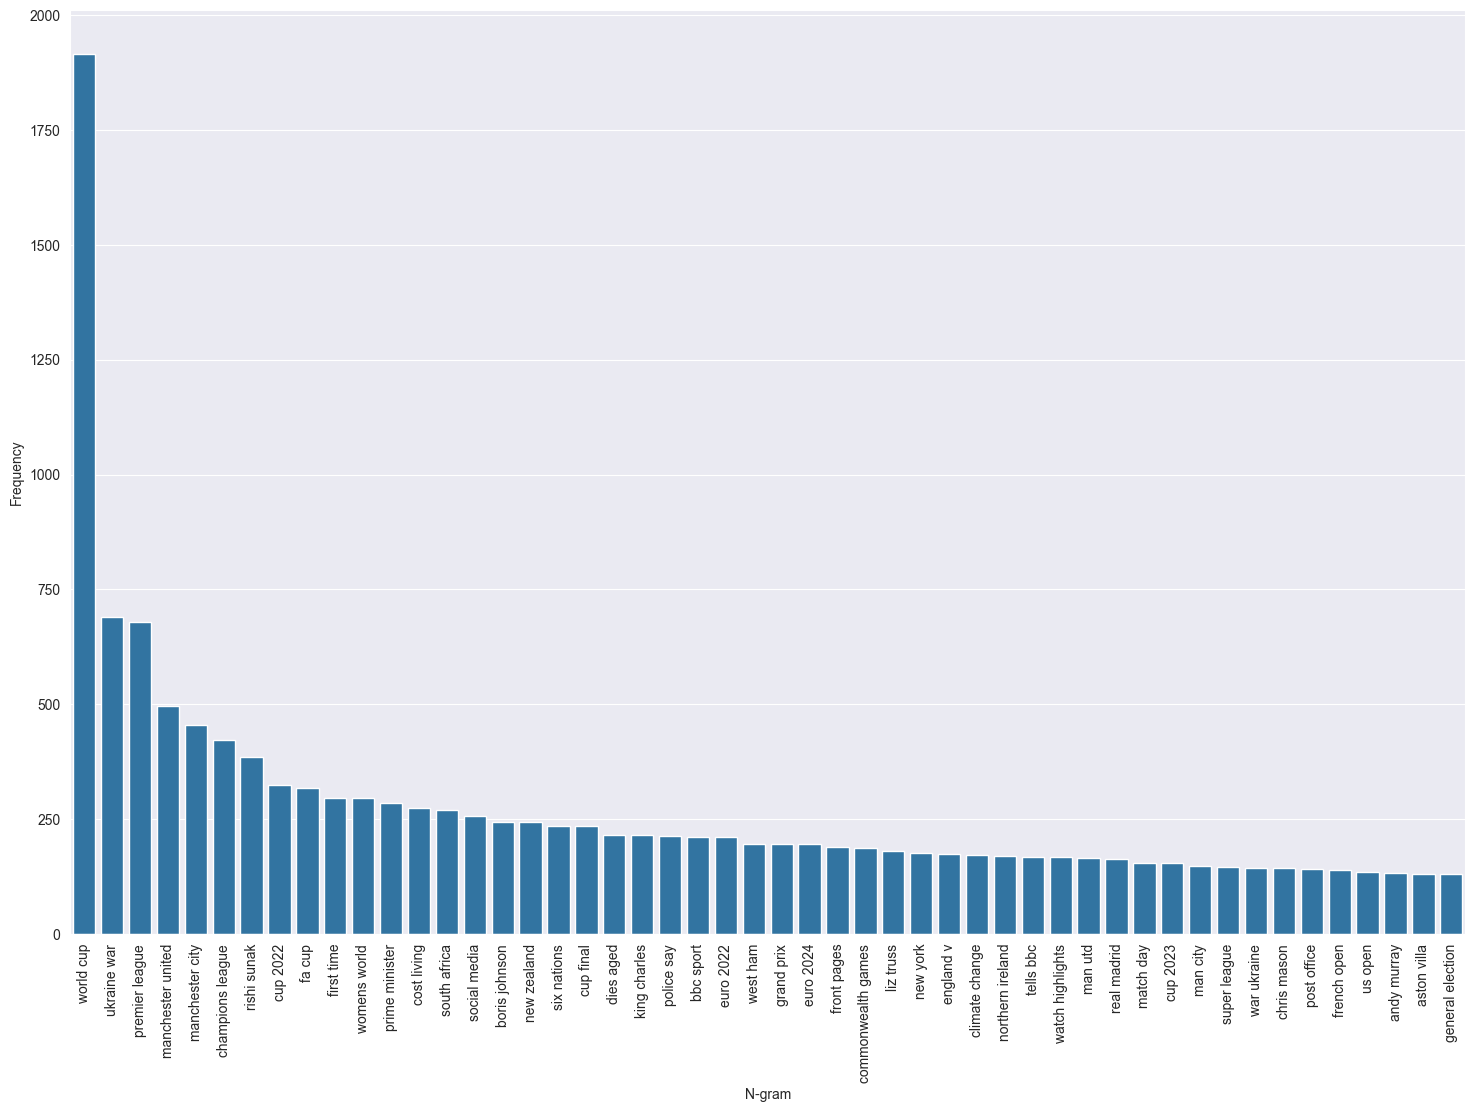

In [25]:
bigram_freq_title['N-gram'] = bigram_freq_title['N-gram'].apply(lambda x: ' '.join(x))
plt.figure(figsize=(18, 12))
sns.barplot(data=bigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

In [14]:
trigrams = find_ngrams(words, 3)
trigrams

[('ukraine', 'angry', 'zelensky'),
 ('angry', 'zelensky', 'vows'),
 ('zelensky', 'vows', 'punish'),
 ('vows', 'punish', 'russian'),
 ('punish', 'russian', 'atrocities'),
 ('russian', 'atrocities', 'ukrainian'),
 ('atrocities', 'ukrainian', 'president'),
 ('ukrainian', 'president', 'says'),
 ('president', 'says', 'country'),
 ('says', 'country', 'forgive'),
 ('country', 'forgive', 'forget'),
 ('forgive', 'forget', 'murder'),
 ('forget', 'murder', 'civilians'),
 ('murder', 'civilians', 'war'),
 ('civilians', 'war', 'ukraine'),
 ('war', 'ukraine', 'taking'),
 ('ukraine', 'taking', 'cover'),
 ('taking', 'cover', 'town'),
 ('cover', 'town', 'attack'),
 ('town', 'attack', 'jeremy'),
 ('attack', 'jeremy', 'bowen'),
 ('jeremy', 'bowen', 'frontline'),
 ('bowen', 'frontline', 'irpin'),
 ('frontline', 'irpin', 'residents'),
 ('irpin', 'residents', 'came'),
 ('residents', 'came', 'russian'),
 ('came', 'russian', 'fire'),
 ('russian', 'fire', 'trying'),
 ('fire', 'trying', 'flee'),
 ('trying', 'fle

In [15]:
trigrams_dist = nltk.FreqDist(trigrams)
trigram_freq_title = pd.DataFrame(trigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
trigram_freq_title

,N-gram,Frequency
0,"(world, cup, 2022)",323
1,"(womens, world, cup)",290
2,"(world, cup, final)",137
3,"(world, cup, 2023)",125
4,"(t20, world, cup)",116
5,"(rugby, world, cup)",104
6,"(erik, ten, hag)",97
7,"(cricket, world, cup)",97
8,"(womens, super, league)",86
9,"(queen, elizabeth, ii)",83


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'world cup 2022'),
  Text(1, 0, 'womens world cup'),
  Text(2, 0, 'world cup final'),
  Text(3, 0, 'world cup 2023'),
  Text(4, 0, 't20 world cup'),
  Text(5, 0, 'rugby world cup'),
  Text(6, 0, 'erik ten hag'),
  Text(7, 0, 'cricket world cup'),
  Text(8, 0, 'womens super league'),
  Text(9, 0, 'queen elizabeth ii'),
  Text(10, 0, 'league world cup'),
  Text(11, 0, 'rugby league world'),
  Text(12, 0, 'premier league title'),
  Text(13, 0, 'first time since'),
  Text(14, 0, 'highlights watch highlights'),
  Text(15, 0, 'world cup england'),
  Text(16, 0, 'bbc sport looks'),
  Text(17, 0, 'world number one'),
  Text(18, 0, 'sir keir starmer'),
  Text(19, 0, 'fa cup final'),
  Text(20, 0,

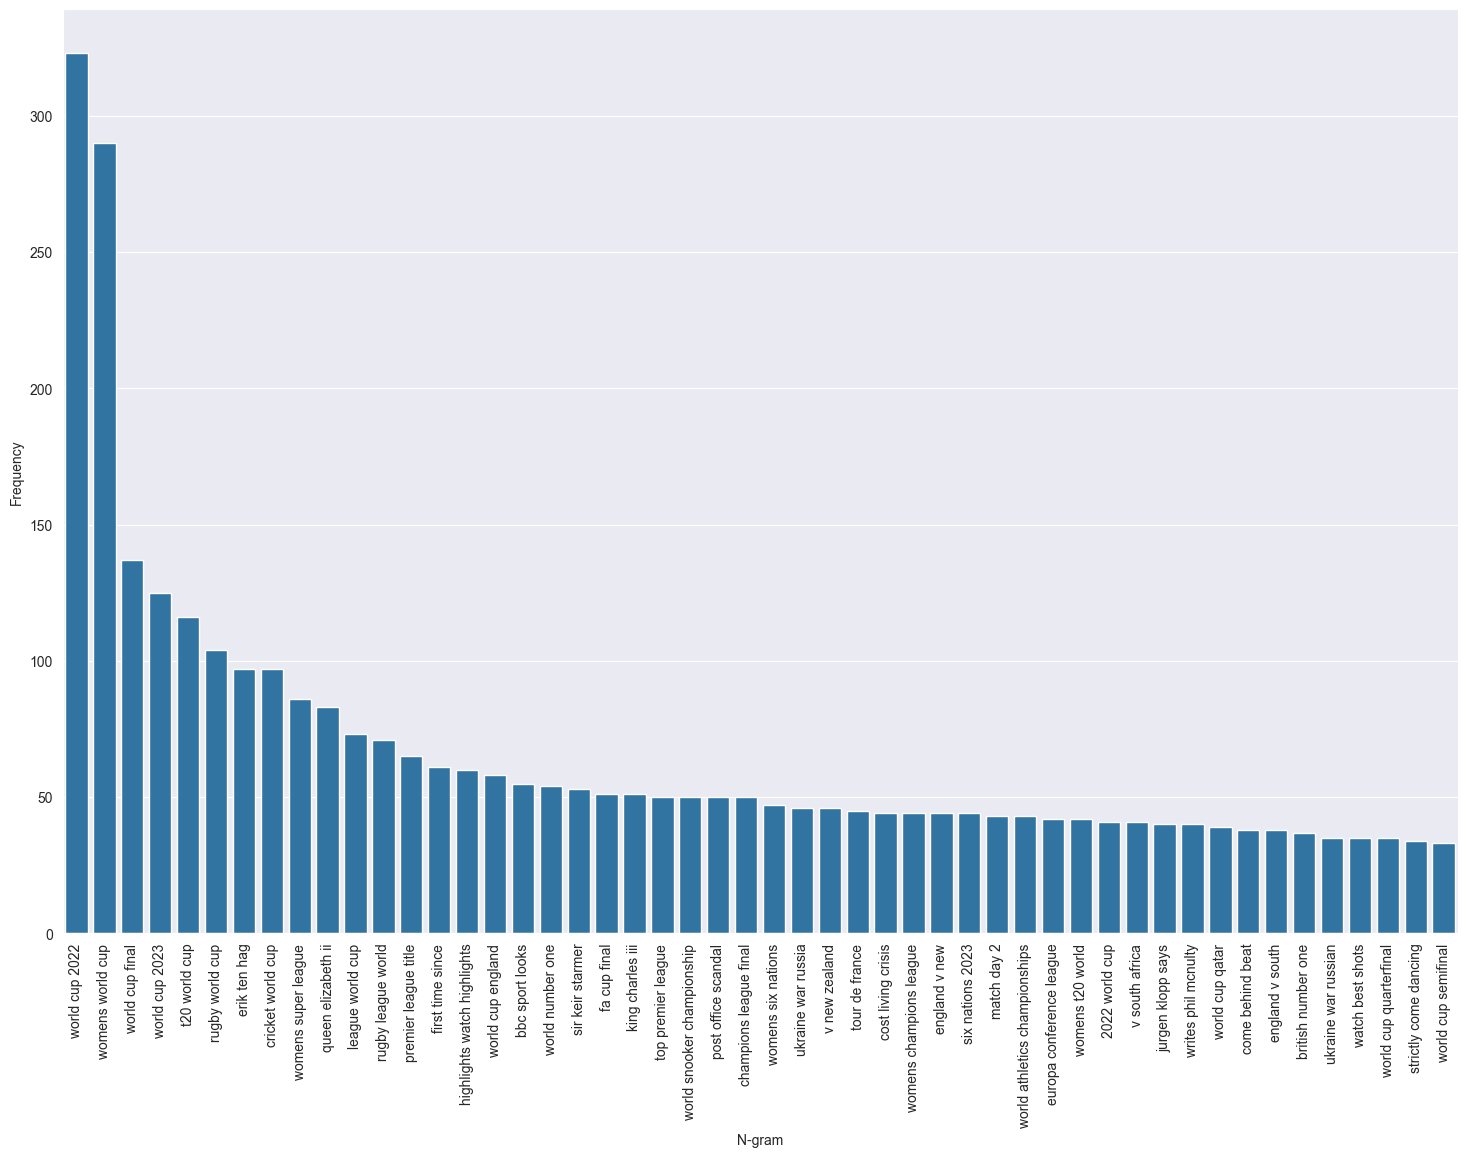

In [26]:
trigram_freq_title['N-gram'] = trigram_freq_title['N-gram'].apply(lambda x: ' '.join(x))
plt.figure(figsize=(18, 12))
sns.barplot(data=trigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

# Cleaning data (removing punctuation)

In [16]:
# lower and remove punctuation
data['combined_cleaned'] = data['combined'].str.lower().apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x))
data

,title,pubDate,guid,link,description,combined,combined_cleaned
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vows to punish russian ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war in ukraine taking cover in a town under at...
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic for global food one o...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soars to highest le...
...,...,...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...,Bell leads England to ODI clean sweep over New...,bell leads england to odi clean sweep over new...
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...,Murrays and all-British battles headline day f...,murrays and allbritish battles headline day fo...
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...,Highlights: Raducanu dominant in win over Mert...,highlights raducanu dominant in win over merte...
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...,Chasing the 'Ghost' - a superstar struck down ...,chasing the ghost a superstar struck down by ...


In [17]:
# remove redundant spaces
data['combined_cleaned'] = data['combined_cleaned'].str.strip()
data

,title,pubDate,guid,link,description,combined,combined_cleaned
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vows to punish russian ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war in ukraine taking cover in a town under at...
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic for global food one o...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soars to highest le...
...,...,...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...,Bell leads England to ODI clean sweep over New...,bell leads england to odi clean sweep over new...
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...,Murrays and all-British battles headline day f...,murrays and allbritish battles headline day fo...
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...,Highlights: Raducanu dominant in win over Mert...,highlights raducanu dominant in win over merte...
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...,Chasing the 'Ghost' - a superstar struck down ...,chasing the ghost a superstar struck down by ...


In [18]:
data['combined_cleaned'][0], data['combined_cleaned'][1]

('ukraine angry zelensky vows to punish russian atrocities the ukrainian president says the country will not forgive or forget those who murder its civilians',
 'war in ukraine taking cover in a town under attack jeremy bowen was on the frontline in irpin as residents came under russian fire while trying to flee')

In [19]:
data['combined_cleaned'].apply(len).describe()

count    32058.000000
mean       162.902708
std         29.194888
min         43.000000
25%        145.000000
50%        156.000000
75%        171.000000
max        321.000000
Name: combined_cleaned, dtype: float64

# Lemmatization

In [20]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('civilians')

'civilian'

In [21]:
data['combined_cleaned']=data['combined_cleaned'].apply(lambda x: ' '.join(map(lemmatizer.lemmatize, filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(x)))))
data['combined'][100], data['combined_cleaned'][100]

('Cost of living: Warning UK faces biggest income squeeze in nearly 50 years The war in Ukraine will lead to an even tighter squeeze on living standards this spring, a think tank says.',
 'cost living warning uk face biggest income squeeze nearly 50 year war ukraine lead even tighter squeeze living standard spring think tank say')

## Normalizing data

In [22]:
cv = CountVectorizer(analyzer='word')
cv_data = cv.fit_transform(data['combined_cleaned'])
dtm_data = pd.DataFrame(cv_data.toarray(), columns=cv.get_feature_names_out())
dtm_data.index = data.index
dtm_data.head(5)

,00,001,007,008,009,0093,01,0100,0102,0140,...,zuu,zuwara,zverev,zverevs,zwelithini,zwerner,zúñigas,élysée,úsuga,šefčovič
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Wordclouds

In [34]:
# Function for generating word clouds
def generate_wordcloud(data, title, bg='black', colormap='Dark2', mask=None):
    wc = WordCloud(width=1600, height=1080, max_words=150, colormap=colormap, mask=mask, background_color=bg).generate_from_frequencies(data)
    plt.figure(figsize=(16,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)),fontsize=26)
    plt.show()

In [41]:
assets = ['100.png', '500.png', 'cloud.png', 'thumb-down.png', 'thumb-up.png']

In [42]:
import requests

assets_url = 'https://raw.githubusercontent.com/StepanTita/fds-final-project/main/assets/'
for asset in assets:
    response = requests.get(assets_url + asset)
    print(response)
    open(f'./assets/{asset}', "wb").write(response.content)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [43]:
ASSETS_PATH = './assets'

In [44]:
f100_mask = np.array(Image.open(ASSETS_PATH + '/100.png'))

In [45]:
latest100indexes = data.sort_values(by=['pubDate'], ascending=False).index

## Latest 100 titles

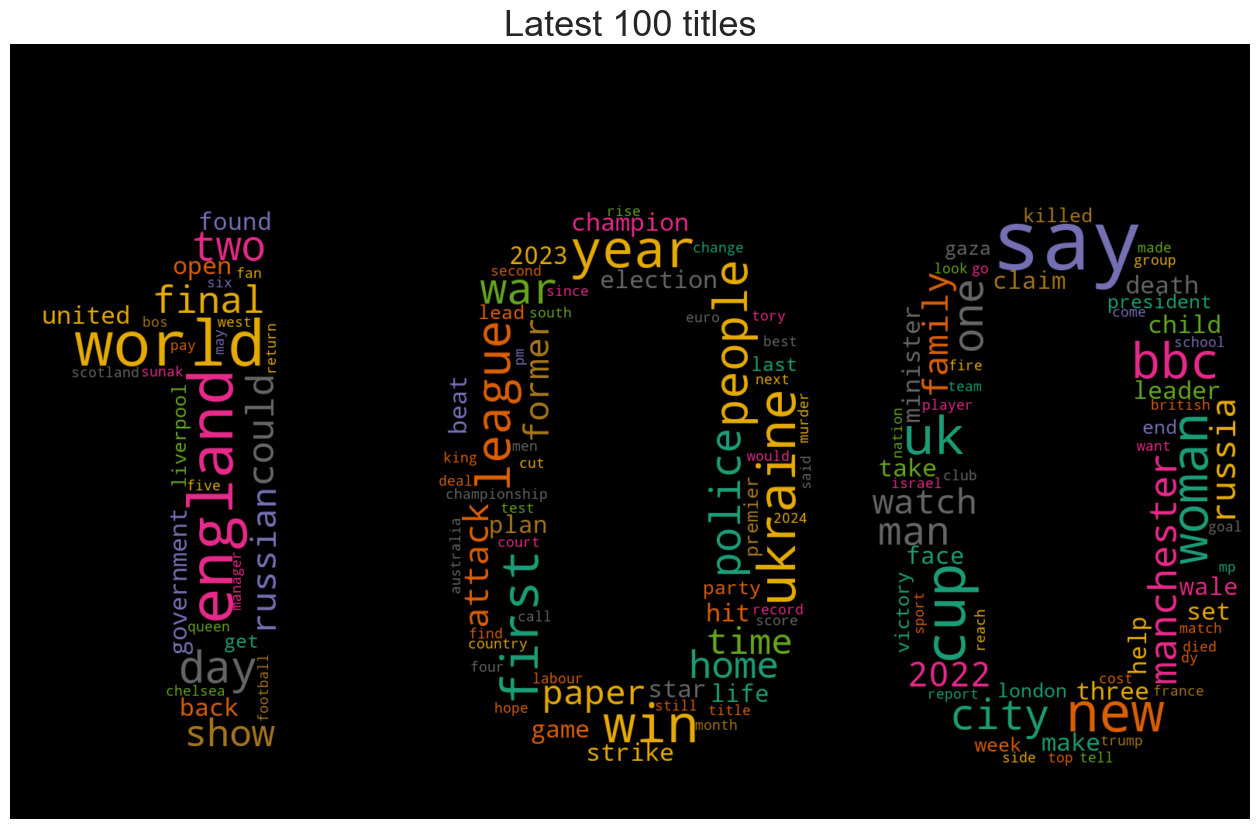

In [46]:
generate_wordcloud(dtm_data.loc[latest100indexes].T.sum(axis=1), 'Latest 100 titles', mask=f100_mask)

## Latest 500 titles

In [47]:
f500_mask = np.array(Image.open(ASSETS_PATH + '/500.png'))

In [48]:
latest500indexes = data.sort_values(by=['pubDate'], ascending=False).index

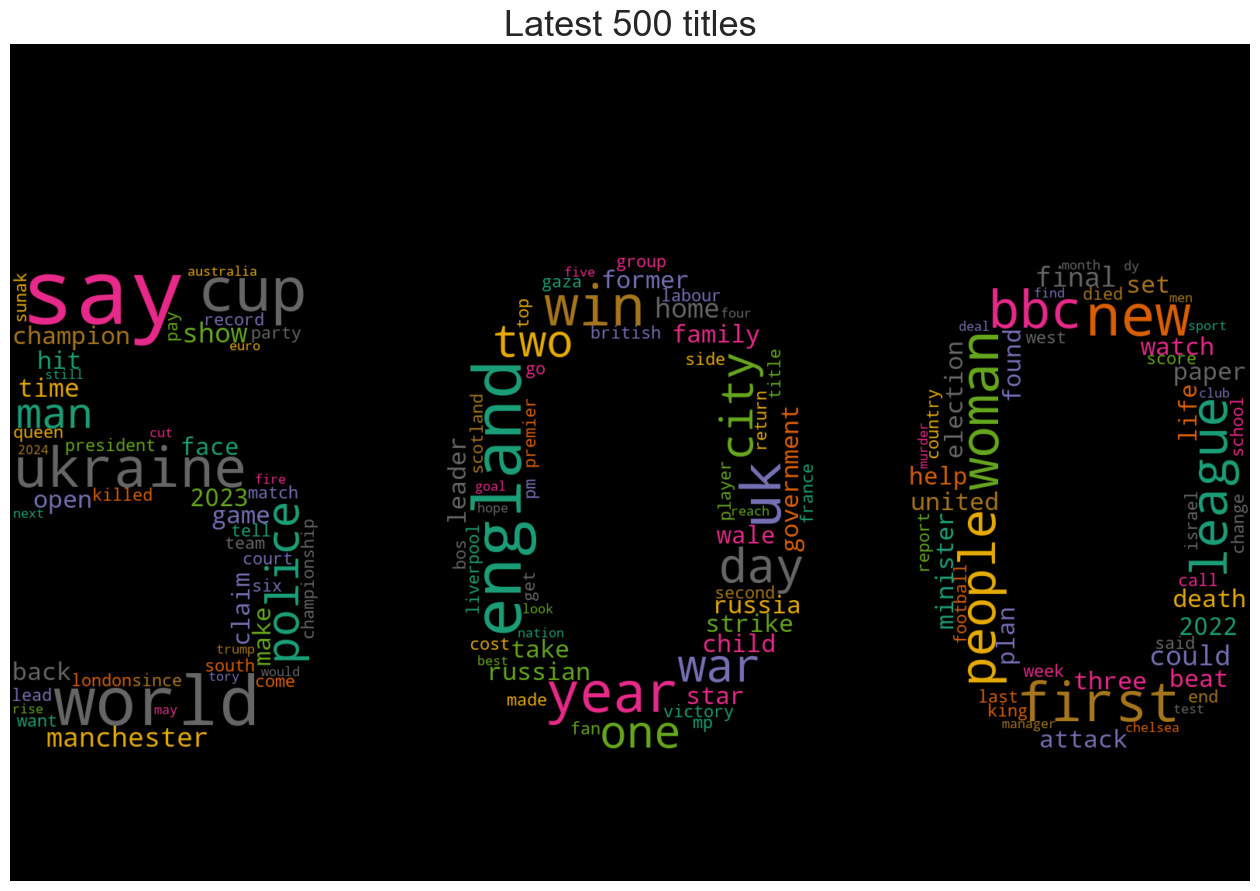

In [49]:
generate_wordcloud(dtm_data.loc[latest500indexes].T.sum(axis=1), 'Latest 500 titles', mask=f500_mask)

In [50]:
data['combined_polarity']=data['combined_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

,title,pubDate,guid,link,description,combined,combined_cleaned,combined_polarity
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vow punish russian atro...,-0.250000
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war ukraine taking cover town attack jeremy bo...,0.000000
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic global food one world...,-0.100000
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...,-0.075000
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soar highest level ...,0.250000
...,...,...,...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...,Bell leads England to ODI clean sweep over New...,bell lead england odi clean sweep new zealand ...,0.359848
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...,Murrays and all-British battles headline day f...,murray allbritish battle headline day four and...,-0.035714
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...,Highlights: Raducanu dominant in win over Mert...,highlight raducanu dominant win mertens emma r...,0.200000
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...,Chasing the 'Ghost' - a superstar struck down ...,chasing ghost superstar struck lightning john ...,0.000000


In [51]:
data.describe()

,pubDate,combined_polarity
count,32058,32058.000000
mean,2023-05-14 21:59:25.703319040,0.047555
min,2013-08-30 01:01:55,-1.000000
25%,2022-10-07 18:49:43.750000128,-0.037879
50%,2023-05-30 23:04:39.500000,0.000000
75%,2023-12-13 21:42:40,0.150000
max,2024-07-04 00:16:37,1.000000
std,NaN,0.247294


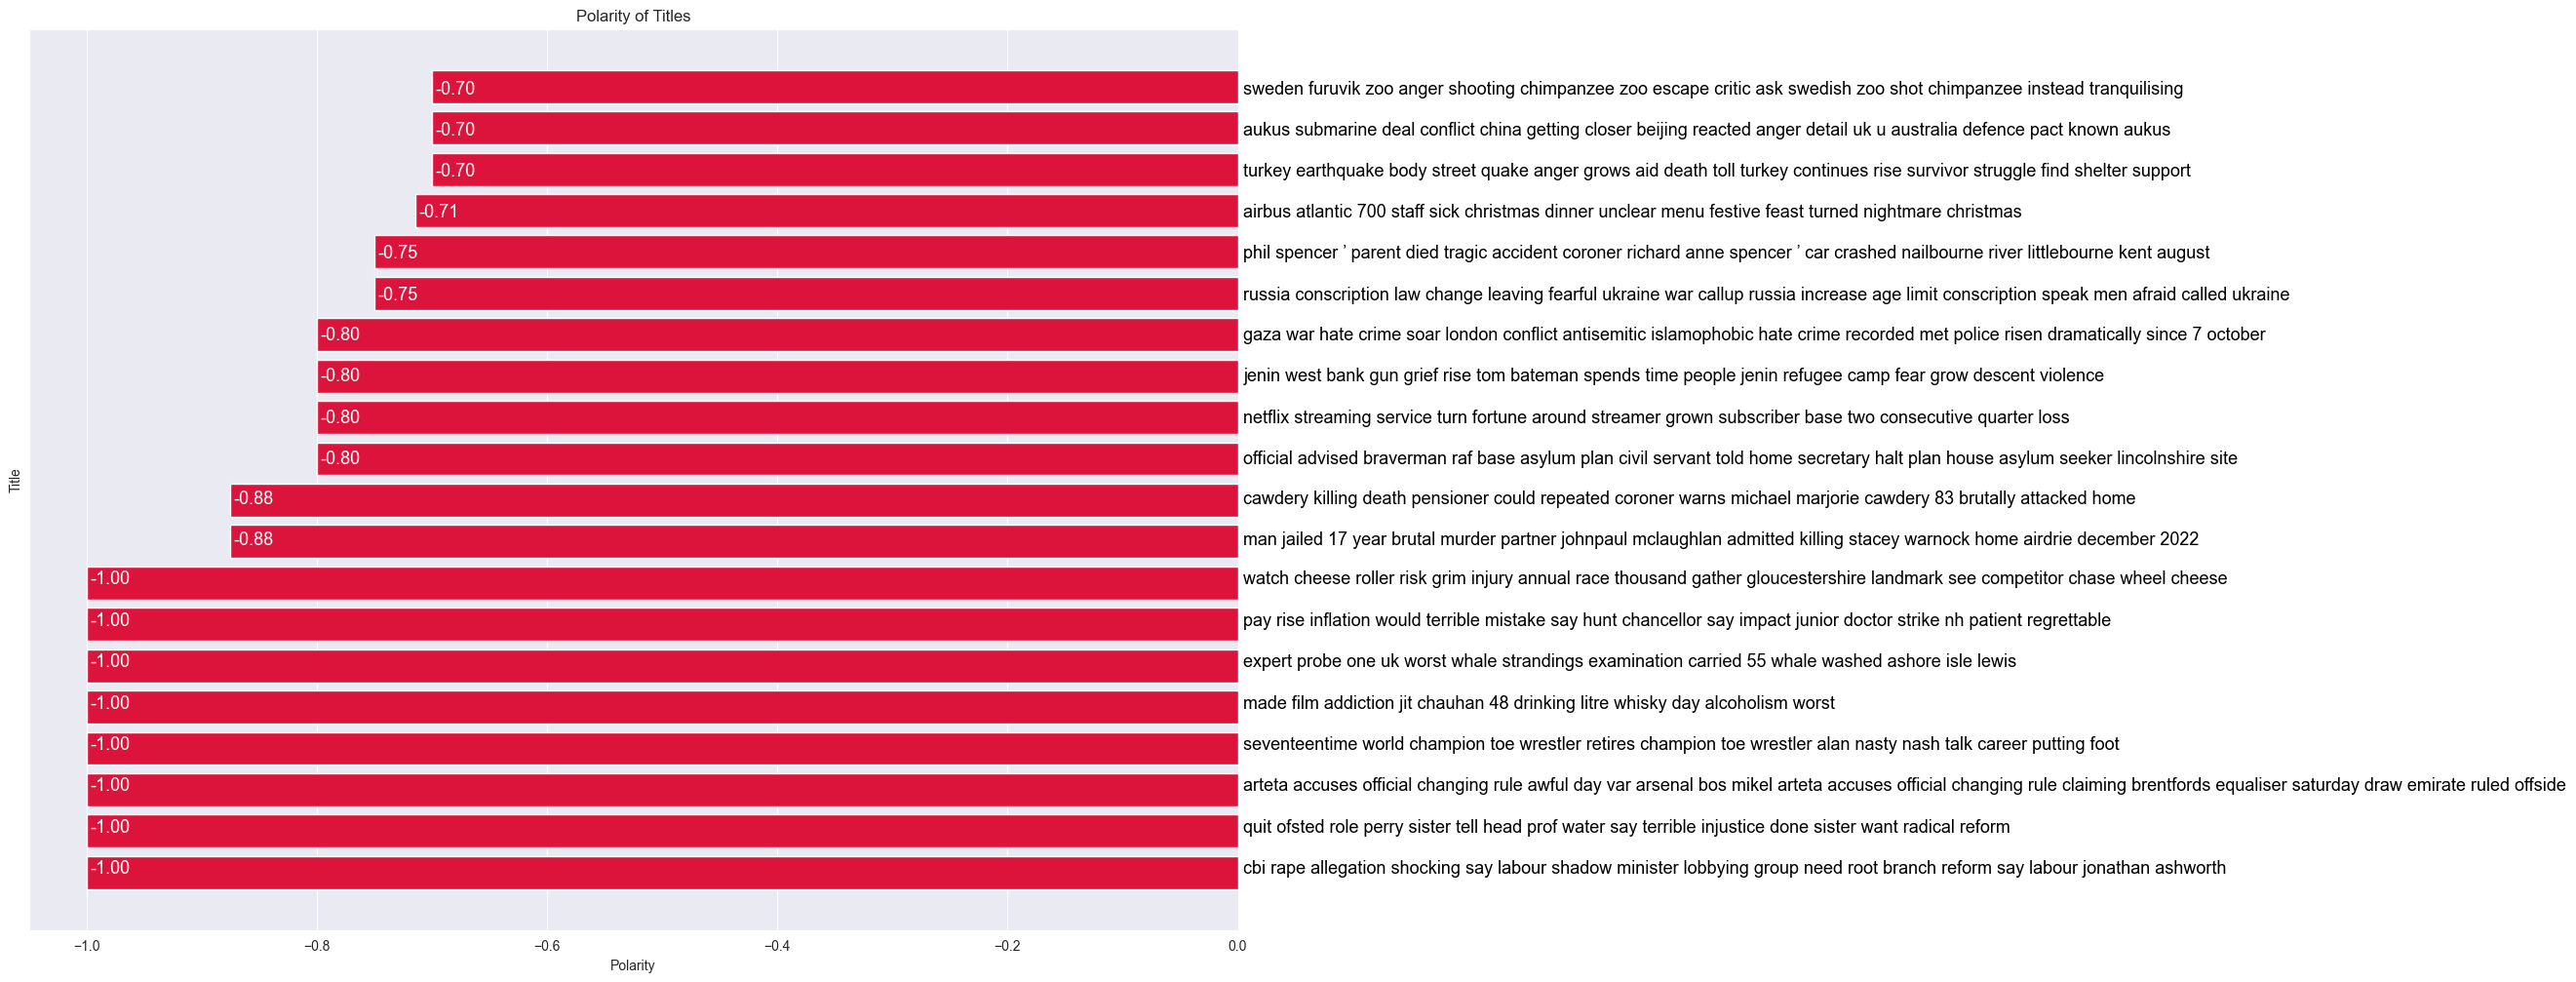

In [52]:
title_polarity_sorted = data['combined_polarity'].sort_values(ascending=True).copy()[:200:10]

plt.figure(figsize=(16,12))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='crimson')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() - bar.get_width() / 2, str(data['combined_cleaned'][polarity_idx]), va='center', fontsize=13, color='black')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() - bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='white')

plt.yticks([])
plt.show()

In [53]:
title_polarity_sorted

14620   -1.000000
14834   -1.000000
12377   -1.000000
8045    -1.000000
6913    -1.000000
17526   -1.000000
14252   -1.000000
30485   -1.000000
29251   -0.875000
24025   -0.875000
15375   -0.800000
8489    -0.800000
4833    -0.800000
21908   -0.800000
18333   -0.750000
24266   -0.750000
24367   -0.714286
12245   -0.700000
13382   -0.700000
10609   -0.700000
Name: combined_polarity, dtype: float64

In [54]:
thumb_down_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png').transpose(method=Image.FLIP_TOP_BOTTOM))
thumb_down_mask-=1
thumb_down_mask[thumb_down_mask == 0] = 255

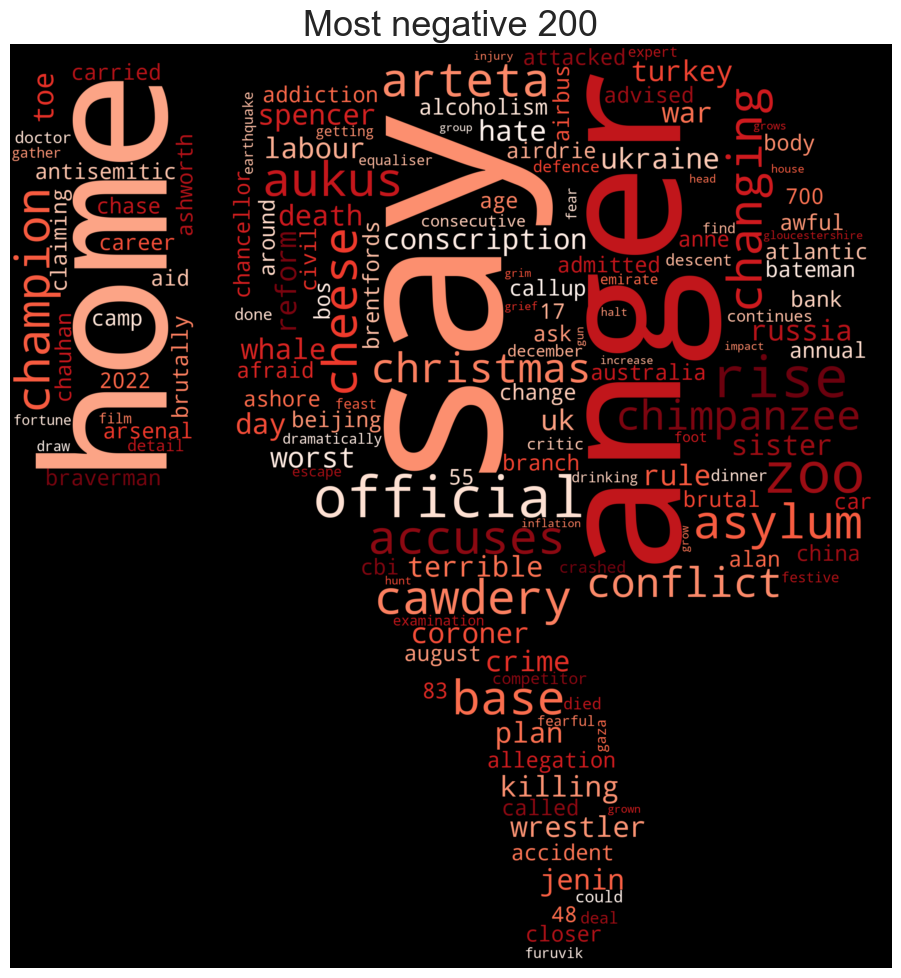

In [55]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most negative 200', colormap='Reds', mask=thumb_down_mask)

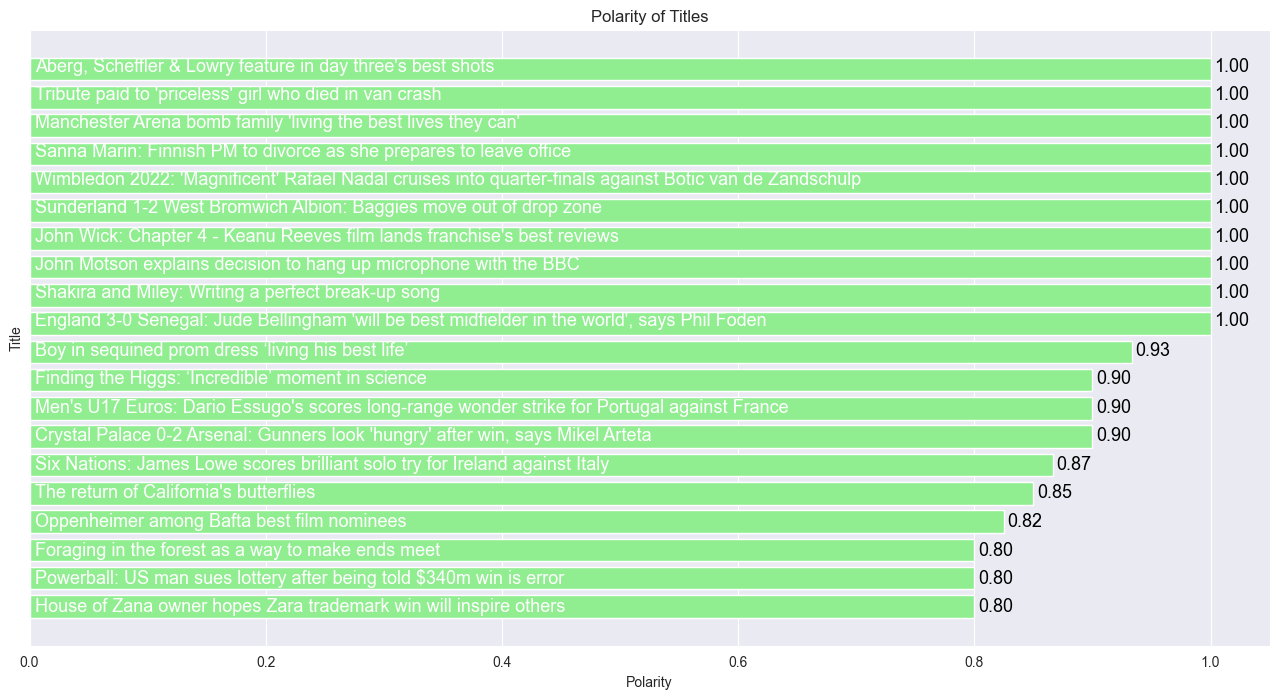

In [56]:
title_polarity_sorted = data['combined_polarity'].sort_values(ascending=True).copy()[-200::10]

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='lightgreen')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() + bar.get_width() / 2, str(data['title'][polarity_idx]), va='center', fontsize=13, color='white')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() + bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='black')
    
plt.yticks([])
plt.show()

In [57]:
thumb_up_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png'))
thumb_up_mask-=1
thumb_up_mask[thumb_up_mask == 0] = 255

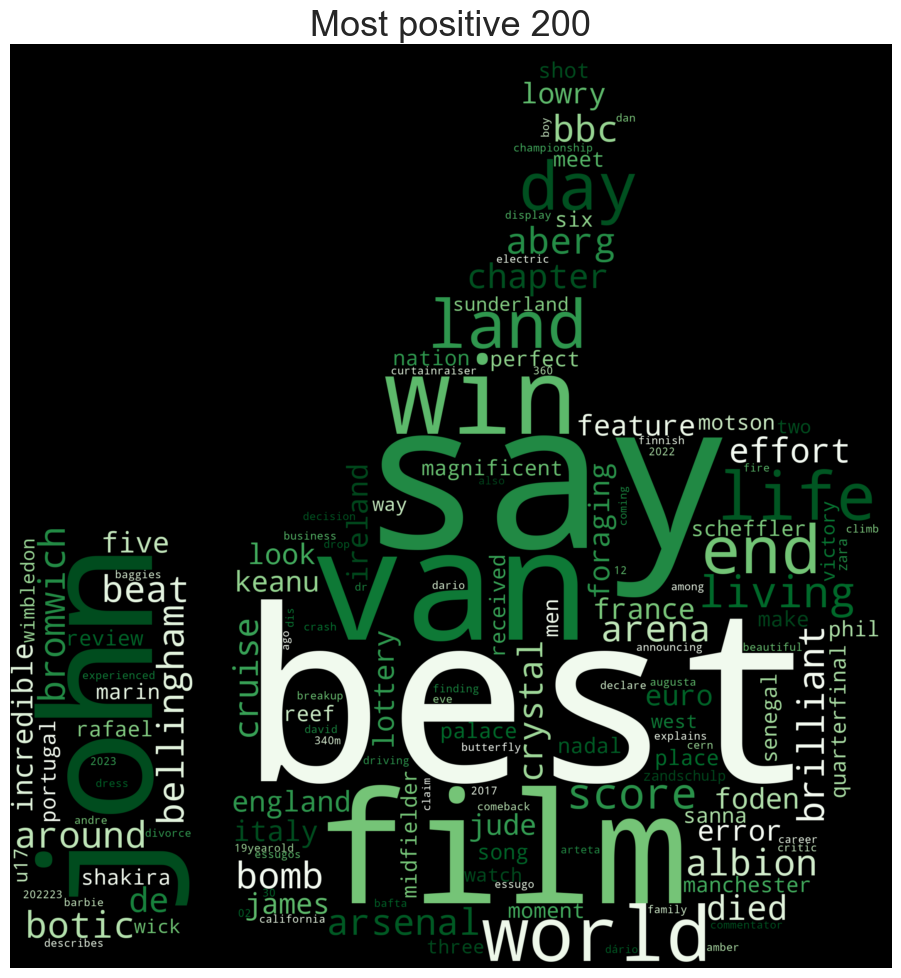

In [58]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most positive 200', colormap='Greens', mask=thumb_up_mask)

# Lemmatization and filtering

In [59]:
word_freq_data_normalized = dtm_data.T
word_freq_data_normalized

,0,1,2,3,4,5,6,7,8,9,...,32048,32049,32050,32051,32052,32053,32054,32055,32056,32057
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwerner,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zúñigas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
élysée,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
úsuga,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
word_freq_data = pd.DataFrame(word_freq_data_normalized.sum(axis=1).reset_index()).rename(columns={'index': 'word', 0: 'freq'})
word_freq_data

,word,freq
0,00,50
1,001,2
2,007,3
3,008,2
4,009,1
...,...,...
34939,zwerner,3
34940,zúñigas,1
34941,élysée,1
34942,úsuga,1


In [61]:
nltk_lems = [lemmatizer.lemmatize(word) for word in nltk_words.words()] #stem the #words in the NLTK corpus so that they’re equivalent to the words in #the dataframe
df_nltk_words = pd.DataFrame() # make a new dataframe with the stemmed #NLTK words
df_nltk_words['word'] = nltk_lems
word_freq_data = word_freq_data[word_freq_data['word'].isin(df_nltk_words['word'])] #keep only #those in the stemmed NLTK corpus
word_freq_data

,word,freq
2010,aa,10
2021,abandon,13
2022,abandoned,60
2024,abatement,1
2026,abattoir,1
...,...,...
34903,zo,1
34908,zombie,9
34911,zone,68
34913,zoo,47


In [62]:
TRIM_QUANTILE = 0.7
word_freq_data[word_freq_data['freq'] >= word_freq_data['freq'].quantile(TRIM_QUANTILE)]

,word,freq
2021,abandon,13
2022,abandoned,60
2032,abbey,25
2090,ability,20
2094,able,96
...,...,...
34805,zak,21
34859,zero,38
34891,zimbabwe,15
34911,zone,68


# Latent Dirichlet Allocation (LDA)

In [23]:
data['tokens'] = data['combined_cleaned'].apply(lambda x: x.split())
data['tokens']

0        [ukraine, angry, zelensky, vow, punish, russia...
1        [war, ukraine, taking, cover, town, attack, je...
2        [ukraine, war, catastrophic, global, food, one...
3        [manchester, arena, bombing, saffie, roussoss,...
4        [ukraine, conflict, oil, price, soar, highest,...
                               ...                        
32053    [bell, lead, england, odi, clean, sweep, new, ...
32054    [murray, allbritish, battle, headline, day, fo...
32055    [highlight, raducanu, dominant, win, mertens, ...
32056    [chasing, ghost, superstar, struck, lightning,...
32057    [le, pen, farright, gate, power, national, ral...
Name: tokens, Length: 32058, dtype: object

In [24]:
from gensim import corpora

# Create a dictionary and corpus
dictionary = corpora.Dictionary(data['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in data['tokens']]

In [25]:
from gensim.models import LdaModel

# Train LDA model
num_topics = 5  #number of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [30]:
lda_model.save('lda_model/lda_model.gensim')

In [31]:
lda_model = LdaModel.load('lda_model/lda_model.gensim')

In [32]:
for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.013*"say" + 0.013*"uk" + 0.010*"new" + 0.009*"people" + 0.008*"could" + 0.007*"government" + 0.006*"bank" + 0.006*"firm" + 0.006*"help" + 0.005*"rise"
Topic 1: 0.021*"england" + 0.019*"win" + 0.014*"cup" + 0.014*"world" + 0.010*"league" + 0.010*"euro" + 0.007*"final" + 0.007*"manchester" + 0.006*"first" + 0.006*"france"
Topic 2: 0.011*"police" + 0.009*"year" + 0.008*"say" + 0.006*"two" + 0.006*"woman" + 0.005*"day" + 0.005*"man" + 0.005*"death" + 0.005*"found" + 0.005*"first"
Topic 3: 0.015*"say" + 0.011*"gaza" + 0.009*"ukraine" + 0.009*"attack" + 0.009*"israel" + 0.008*"war" + 0.008*"u" + 0.006*"bbc" + 0.006*"israeli" + 0.005*"russia"
Topic 4: 0.018*"say" + 0.014*"election" + 0.013*"2024" + 0.010*"party" + 0.009*"labour" + 0.008*"former" + 0.007*"minister" + 0.006*"general" + 0.006*"paper" + 0.006*"sir"


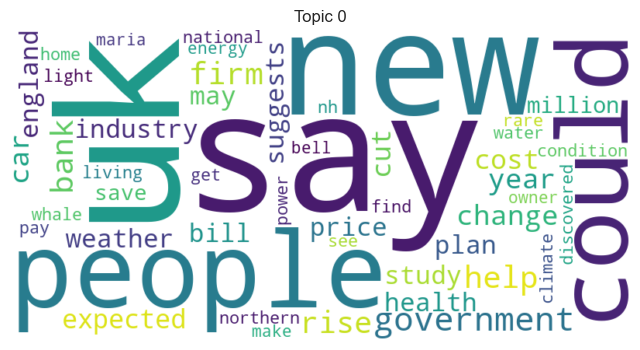

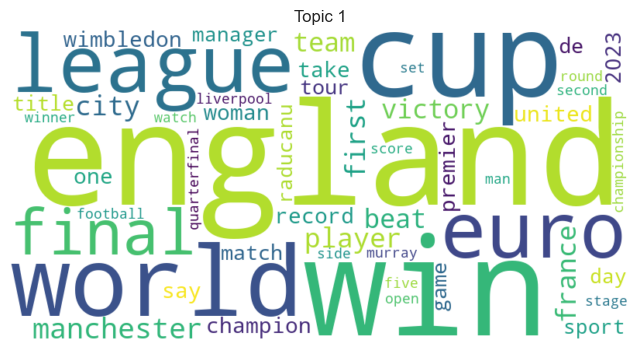

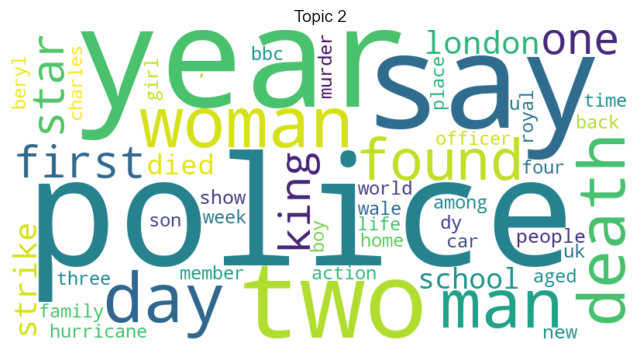

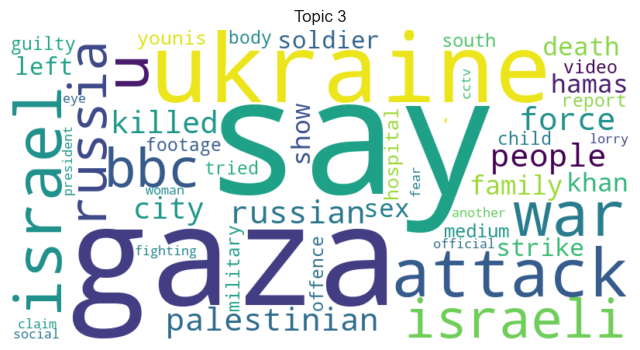

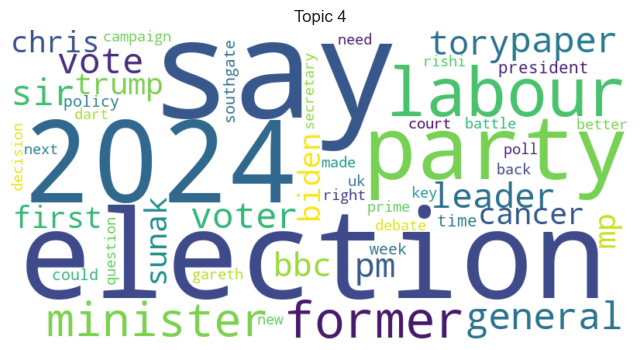

In [33]:
for topic_id in range(num_topics):
    plt.figure(figsize=(8, 6))
    plt.title(f'Topic {topic_id}')
    word_freq = dict(lda_model.show_topic(topic_id, topn=50))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# TFiDF Vectorization

In [63]:
stopwords = list(word_freq_data[word_freq_data['freq'] < word_freq_data['freq'].quantile(TRIM_QUANTILE)]['word'])
vec_vocab = list(word_freq_data[word_freq_data['freq'] >= word_freq_data['freq'].quantile(TRIM_QUANTILE)]['word'])

In [64]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=stopwords, vocabulary=vec_vocab)
tfidf_vectorizer

TfidfVectorizer(stop_words=['aa', 'abatement', 'abattoir', 'abbas', 'abbess',
                            'abdication', 'abdomen', 'abdominal', 'abduct',
                            'abduction', 'abed', 'abey', 'abhorrent', 'abigail',
                            'abject', 'ablaze', 'aboard', 'abolish',
                            'abolition', 'aboriginal', 'abort', 'aborted',
                            'abound', 'abrupt', 'abruptly', 'abscond',
                            'absentee', 'absorbing', 'abstain', 'absurd', ...],
                vocabulary=['abandon', 'abandoned', 'abbey', 'ability', 'able',
                            'abortion', 'abroad', 'absence', 'absent',
                            'absolute', 'absolutely', 'abu', 'abuse', 'abuser',
                            'abusive', 'academic', 'academy', 'accept',
                            'accepted', 'access', 'accident', 'accidental',
                            'accidentally', 'accommodation', 'according',
                            'account', 'accusation', 'accuse', 'accused',
                            'accuser', ...])

In [65]:
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_cleaned'])
tfidf_matrix

<32058x4137 sparse matrix of type '<class 'numpy.float64'>'
	with 340320 stored elements in Compressed Sparse Row format>

In [66]:
tfidf_data = pd.DataFrame(tfidf_matrix.toarray())
tfidf_data

,0,1,2,3,4,5,6,7,8,9,...,4127,4128,4129,4130,4131,4132,4133,4134,4135,4136
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['abandon', 'abandoned', 'abbey', ..., 'zimbabwe', 'zone', 'zoo'],
      dtype=object)

In [68]:
tfidf_data.columns = feature_names
tfidf_data

,abandon,abandoned,abbey,ability,able,abortion,abroad,absence,absent,absolute,...,york,young,younger,youngster,youth,zak,zero,zimbabwe,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TruncatedSVD

### during the experiments following configurations were tried:

* 1000 components - 10 clusters

* 100 components - 10 clusters

* 50 components - 10 clusters

* 100 components - 5 clusters

* 100 components - 15 clusters

In [69]:
tsvd = TruncatedSVD(n_components=100, random_state=37)
vec_matrix_tsvd = tsvd.fit_transform(tfidf_matrix)
vec_matrix_tsvd

array([[ 0.07409934, -0.09748648, -0.0454221 , ...,  0.05811306,
        -0.00679365,  0.04120957],
       [ 0.06400569, -0.09238105, -0.03444469, ...,  0.00309822,
        -0.02335922, -0.01551898],
       [ 0.1622575 , -0.04347748, -0.10540347, ..., -0.06193971,
         0.00394063,  0.01651555],
       ...,
       [ 0.10242019,  0.04526683,  0.12026327, ..., -0.05261722,
        -0.01335525,  0.00642233],
       [ 0.21305463,  0.16106835, -0.02163448, ..., -0.01107908,
         0.04260478,  0.02039061],
       [ 0.0369382 , -0.03847248, -0.00550357, ..., -0.01996264,
         0.0243991 ,  0.01416472]])

In [70]:
pd.DataFrame(vec_matrix_tsvd)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.074099,-0.097486,-0.045422,0.041352,0.057487,-0.026063,-0.030431,0.055439,0.011091,-0.015423,...,-0.006337,-0.047351,0.041274,0.010012,0.016172,-0.006539,-0.017127,0.058113,-0.006794,0.041210
1,0.064006,-0.092381,-0.034445,0.045707,0.087451,0.192249,0.031612,0.075821,0.001088,-0.002988,...,0.019028,0.011581,-0.018670,0.036831,-0.027339,-0.029019,0.030773,0.003098,-0.023359,-0.015519
2,0.162258,-0.043477,-0.105403,-0.018556,0.120204,0.079267,-0.047062,-0.003442,-0.015822,0.024958,...,-0.026889,-0.011135,-0.062213,0.030974,-0.020544,0.013770,-0.006549,-0.061940,0.003941,0.016516
3,0.035204,-0.040071,-0.010111,0.015901,-0.024004,0.023517,-0.015880,-0.017436,0.002155,-0.004844,...,-0.020095,-0.001932,0.038134,-0.034343,-0.007965,0.038344,-0.012077,-0.036738,0.037984,-0.047644
4,0.049013,-0.065398,-0.024925,-0.070059,0.011066,0.009299,0.015335,-0.090777,-0.006996,0.063069,...,-0.039104,0.063097,-0.030844,-0.010750,-0.003504,0.028268,-0.054313,-0.008241,0.044129,0.019000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32053,0.099252,-0.019002,0.048720,-0.092492,-0.074196,0.023369,-0.011242,-0.007829,-0.041917,-0.026995,...,0.001908,-0.017379,0.014687,-0.007434,0.035514,0.022098,0.018900,-0.007505,0.041127,-0.015194
32054,0.088474,-0.040707,0.027867,0.015188,-0.059764,0.053194,0.012402,-0.000208,-0.031327,-0.014059,...,-0.030835,0.025070,-0.011166,0.022258,-0.035819,0.019223,-0.063484,-0.000716,0.075591,0.055383
32055,0.102420,0.045267,0.120263,-0.034577,-0.033031,0.008640,-0.048301,0.085817,-0.097423,-0.043514,...,0.002310,0.026236,-0.023841,-0.007452,-0.000488,-0.001433,0.040484,-0.052617,-0.013355,0.006422
32056,0.213055,0.161068,-0.021634,0.090104,0.044146,-0.019416,0.105379,-0.050836,0.073939,-0.047014,...,0.002898,0.045280,-0.033460,0.030313,-0.014389,0.009501,0.022368,-0.011079,0.042605,0.020391


# Clustering

## KMeans

In [71]:
clst10 = KMeans(n_clusters=10, verbose=0, random_state=37)
clst10.fit(vec_matrix_tsvd)

KMeans(n_clusters=10, random_state=37)

In [72]:
data['label'] = clst10.labels_
data

,title,pubDate,guid,link,description,combined,combined_cleaned,combined_polarity,label
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vow punish russian atro...,-0.250000,3
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war ukraine taking cover town attack jeremy bo...,0.000000,6
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic global food one world...,-0.100000,6
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...,-0.075000,6
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soar highest level ...,0.250000,6
...,...,...,...,...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...,Bell leads England to ODI clean sweep over New...,bell lead england odi clean sweep new zealand ...,0.359848,2
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...,Murrays and all-British battles headline day f...,murray allbritish battle headline day four and...,-0.035714,6
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...,Highlights: Raducanu dominant in win over Mert...,highlight raducanu dominant win mertens emma r...,0.200000,6
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...,Chasing the 'Ghost' - a superstar struck down ...,chasing ghost superstar struck lightning john ...,0.000000,7


In [73]:
labels_count_data = data[['description', 'label']].groupby(['label', 'description']).count()
labels_count_data

Empty DataFrame
Columns: []
Index: [(0,  Snarky jibes and silly memes have been a hit on TikTok but the real social battle is  elsewhere.), (0, "Lies have consequences," says a lawyer for the voting firm about the network's false election claims.), (0, A BBC project investigates the election content promoted by social media by tracking dozens of phones.), (0, A French election is driving down the value of French listed companies, analysts say), (0, A Friday bank holiday for King Charles's coronation would clash with vote counting in England.), (0, A Holyrood complaint claims that stamps bought on MSPs' expenses were passed to UK election candidates.), (0, A breakdown of what we know about Sir Keir Starmer's offer to voters at the next general election.), (0, A campaign group says Travellers are treated like "political footballs" during election campaigns.), (0, A closer look at what Argentina's president-elect has said he will do once he is in office.), (0, A deaf campaigner says she was "very disappointed" to not be able to follow Tuesday's live debate.), (0, A five-party alliance led by Jean-Luc Mélenchon aims to deny the president control of parliament.), (0, A fourth Tory is being investigated for allegedly placing dozens of bets on the general election date.), (0, A group representing northern businesses wants a property revaluation before the next election.), (0, A landslide victory shows it is still his Republican Party, while no clear rival emerged as a challenger.), (0, A large portion of US voters see immigration as a primary concern ahead of the November election. ), (0, A leading think tank warns more tax rises or cuts to public services could lie ahead.), (0, A long-running internal party feud is putting an increasing dent in Labour's general election funds.), (0, A long-time pariah, the Sweden Democrats are now the country's second-largest party.), (0, A lot has happened in the five years since the United Kingdom last went to the polls in a general election.), (0, A minister loyal to Rishi Sunak tells BBC there are only two options now: “Lose your head or get on with the campaign"), (0, A new year, and all the political parties are focusing their planning and attention on the polls ahead.), (0, A potential re-run of the 2020 US election is on the cards - that's not exciting voters for now.), (0, A rejuvenated main opposition has intensified protests ahead of general elections in January.), (0, A rise in drug crime in the once-peaceful country has dominated the build-up to Sunday's election.), (0, A senior Tory MP leads calls for more government action to prevent AI sabotaging British democracy.), (0, A seven-party debate is to be held on Friday, before a Question Time special and head-to-head event.), (0, A similar display of anger in November could swing who wins the White House, writes BBC North America editor Sarah Smith.), (0, A single opinion poll shaped a day on the campaign trail - but  Nigel Farage has had false dawns before.), (0, A state visit to the UK by the Emperor and Empress of Japan is to go ahead during the election campaign.), (0, A top far-right German politician says he will pull back from campaigning for the EU elections.), (0, A total of 807 candidates are competing for 462 seats in council chambers across Northern Ireland.), (0, A veteran politician, Anthony Albanese will lead the first Labor government in almost a decade.), (0, A year ahead of the US presidential election, and anything could happen.), (0, A young, progressive party won more seats than any other. Will the senate and courts let them govern?), (0, Adam and Laura answer your election questions), (0, Adam and team unpack the first TV debate of the General Election campaign), (0, Adrian Ramsay and Nigel Farage are pressed by the audience on their candidates, tax and the US election. ), (0, After a dramatic three-way race, Petteri Orpo claims victory in Finland's election.), (0, After a year of political turmoil, will voters in S

In [74]:
assign_ratio = labels_count_data.reset_index()['label'].value_counts() / labels_count_data.shape[0]
assign_ratio

label
6    0.704972
2    0.054963
7    0.050877
4    0.045948
9    0.040084
5    0.028854
3    0.024799
0    0.021555
8    0.019153
1    0.008797
Name: count, dtype: float64

In [75]:
assign_ratio.sum()

1.0

In [76]:
flat_labels_count_data = labels_count_data.reset_index()
for i in assign_ratio.index:
    flat_labels_count_data.loc[flat_labels_count_data['label'] == i, 'ratio'] = assign_ratio.loc[i]
flat_labels_count_data.groupby(['label', 'ratio', 'description']).first(5)

Empty DataFrame
Columns: []
Index: [(0, 0.021554682138623743,  Snarky jibes and silly memes have been a hit on TikTok but the real social battle is  elsewhere.), (0, 0.021554682138623743, "Lies have consequences," says a lawyer for the voting firm about the network's false election claims.), (0, 0.021554682138623743, A BBC project investigates the election content promoted by social media by tracking dozens of phones.), (0, 0.021554682138623743, A French election is driving down the value of French listed companies, analysts say), (0, 0.021554682138623743, A Friday bank holiday for King Charles's coronation would clash with vote counting in England.), (0, 0.021554682138623743, A Holyrood complaint claims that stamps bought on MSPs' expenses were passed to UK election candidates.), (0, 0.021554682138623743, A breakdown of what we know about Sir Keir Starmer's offer to voters at the next general election.), (0, 0.021554682138623743, A campaign group says Travellers are treated like "political footballs" during election campaigns.), (0, 0.021554682138623743, A closer look at what Argentina's president-elect has said he will do once he is in office.), (0, 0.021554682138623743, A deaf campaigner says she was "very disappointed" to not be able to follow Tuesday's live debate.), (0, 0.021554682138623743, A five-party alliance led by Jean-Luc Mélenchon aims to deny the president control of parliament.), (0, 0.021554682138623743, A fourth Tory is being investigated for allegedly placing dozens of bets on the general election date.), (0, 0.021554682138623743, A group representing northern businesses wants a property revaluation before the next election.), (0, 0.021554682138623743, A landslide victory shows it is still his Republican Party, while no clear rival emerged as a challenger.), (0, 0.021554682138623743, A large portion of US voters see immigration as a primary concern ahead of the November election. ), (0, 0.021554682138623743, A leading think tank warns more tax rises or cuts to public services could lie ahead.), (0, 0.021554682138623743, A long-running internal party feud is putting an increasing dent in Labour's general election funds.), (0, 0.021554682138623743, A long-time pariah, the Sweden Democrats are now the country's second-largest party.), (0, 0.021554682138623743, A lot has happened in the five years since the United Kingdom last went to the polls in a general election.), (0, 0.021554682138623743, A minister loyal to Rishi Sunak tells BBC there are only two options now: “Lose your head or get on with the campaign"), (0, 0.021554682138623743, A new year, and all the political parties are focusing their planning and attention on the polls ahead.), (0, 0.021554682138623743, A potential re-run of the 2020 US election is on the cards - that's not exciting voters for now.), (0, 0.021554682138623743, A rejuvenated main opposition has intensified protests ahead of general elections in January.), (0, 0.021554682138623743, A rise in drug crime in the once-peaceful country has dominated the build-up to Sunday's election.), (0, 0.021554682138623743, A senior Tory MP leads calls for more government action to prevent AI sabotaging British democracy.), (0, 0.021554682138623743, A seven-party debate is to be held on Friday, before a Question Time special and head-to-head event.), (0, 0.021554682138623743, A similar display of anger in November could swing who wins the White House, writes BBC North America editor Sarah Smith.), (0, 0.021554682138623743, A single opinion poll shaped a day on the campaign trail - but  Nigel Farage has had false dawns before.), (0, 0.021554682138623743, A state visit to the UK by the Emperor and Empress of Japan is to go ahead during the election campaign.), (0, 0.021554682138623743, A top far-right German politician says he will pull back from campaigning for the EU elections.), (0, 0.021554682138623743, A total of 807 candidates are competing for 462 seats in council chambers across Northern Ireland

In [77]:
tfidf_data

,abandon,abandoned,abbey,ability,able,abortion,abroad,absence,absent,absolute,...,york,young,younger,youngster,youth,zak,zero,zimbabwe,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
def to_viz_data(data, tfidf_data, labels):
    transformed_data = []
    for label in labels:
        new_data = tfidf_data[tfidf_data[data['label'] == label].idxmax(axis=1)].max()[:200]
        transformed_data.append(pd.concat([new_data.reset_index(), pd.Series([label] * len(new_data))], axis=1))
    viz_data = pd.concat(transformed_data)
    viz_data.columns = ['word', 'tfidf', 'label']
    return viz_data

In [79]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

,word,tfidf,label
0,atrocity,0.692562,3
1,measure,0.531674,3
2,sanction,0.710527,3
3,worried,0.583472,3
4,perry,0.611244,3
...,...,...,...
195,henry,0.706847,1
196,highland,0.638608,1
197,film,0.622862,1
198,alan,0.587433,1


In [80]:
viz_data.to_csv('./Data/combined-kmeans-clusters.csv', index=False)

In [81]:
tfidf_data

,abandon,abandoned,abbey,ability,able,abortion,abroad,absence,absent,absolute,...,york,young,younger,youngster,youth,zak,zero,zimbabwe,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualizing the results

In [82]:
viz_data.sort_values('label').groupby('label').head(10).reset_index(drop=True)

,word,tfidf,label
0,sworn,0.645779,0
1,leadership,0.618950,0
2,neck,0.673997,0
3,underdog,0.614314,0
4,testify,0.471944,0
...,...,...,...
95,trophy,0.610065,9
96,ranger,0.696632,9
97,race,0.604728,9
98,lot,0.553399,9


In [83]:
def visualize_clusters(viz_data):
    viz_data = viz_data.copy()
    viz_data['label'] += np.abs(viz_data['label'].min())
    viz_data = viz_data.sort_values('label').groupby('label').head(10)
    fig = px.scatter(viz_data, x='label', y='tfidf', color='label', text='word', hover_data=['label', 'tfidf', 'word'])
    fig.update_layout(
        font=dict(
            family='Courier New, monospace',
            size=18,  # Set the font size here
            color='black'
        ),
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 1
        ),
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 0.05
        )
    )
    fig.update_traces(mode='text', selector=dict(type='scatter'), textfont_size=(viz_data['tfidf'] * 25).values)
    fig.for_each_trace(lambda t: t.update(textfont_color=np.array(px.colors.qualitative.Dark24)[t.marker.color], textposition='bottom center'))
    fig.show()

In [84]:
visualize_clusters(viz_data)

## Infer real results

In [85]:
def infer_topic(data):
    topics_data = pd.DataFrame()
    for kw in data['word']:
        print('Starting: ', kw)
        trends.build_payload(kw_list=[kw])
        
        backoff = 1.0001
        while True:
            try:
                related_topics = trends.related_topics()[kw]['top'][['topic_title', 'topic_type']][:3].T
                break
            except ResponseError as e:
                print('Retrying:', e)
                time.sleep(10 * backoff)
                backoff = pow(backoff, 2)
            except Error as e:
                print('Bad situation...')
                time.sleep(10)
                backoff = pow(backoff, 2)
            print('Using backoff: ', backoff)
        n = min(len(related_topics.loc['topic_title', :]), len(related_topics.loc['topic_type', :]))
        tmp = pd.DataFrame(pd.concat([related_topics.loc['topic_title', :], related_topics.loc['topic_type', :]])).T
        tmp.columns = [f'topic_title_{c}' for c in tmp.columns[:n]] + [f'topic_type_{c}' for c in tmp.columns[n:]]

        topics_data = topics_data.append(tmp)
        
        print('Finished: ', kw)
        print('*' * 20)
        time.sleep(1)
    return topics_data

In [86]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Agglomerative (ward)

In [87]:
clst_agg_ward = AgglomerativeClustering(n_clusters=10, linkage='ward')
clst_agg_ward.fit(vec_matrix_tsvd)

AgglomerativeClustering(n_clusters=10)

In [88]:
data['label'] = clst_agg_ward.labels_
data

,title,pubDate,guid,link,description,combined,combined_cleaned,combined_polarity,label
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vow punish russian atro...,-0.250000,5
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war ukraine taking cover town attack jeremy bo...,0.000000,1
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic global food one world...,-0.100000,2
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...,-0.075000,2
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soar highest level ...,0.250000,2
...,...,...,...,...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...,Bell leads England to ODI clean sweep over New...,bell lead england odi clean sweep new zealand ...,0.359848,2
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...,Murrays and all-British battles headline day f...,murray allbritish battle headline day four and...,-0.035714,2
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...,Highlights: Raducanu dominant in win over Mert...,highlight raducanu dominant win mertens emma r...,0.200000,8
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...,Chasing the 'Ghost' - a superstar struck down ...,chasing ghost superstar struck lightning john ...,0.000000,3


In [89]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

label
2    0.609208
0    0.165824
1    0.076393
5    0.041300
3    0.024612
4    0.020650
9    0.017687
7    0.017156
6    0.014162
8    0.013008
Name: count, dtype: float64

In [90]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

,word,tfidf,label
0,atrocity,0.692562,5
1,streaming,0.677055,5
2,volunteer,0.706061,5
3,troll,0.783674,5
4,helicopter,0.626713,5
...,...,...,...
195,id,0.596076,9
196,sewage,0.704826,9
197,voter,0.620532,9
198,local,0.563625,9


In [91]:
viz_data.to_csv('./Data/combined-agg-ward-clusters.csv', index=False)

In [92]:
visualize_clusters(viz_data)

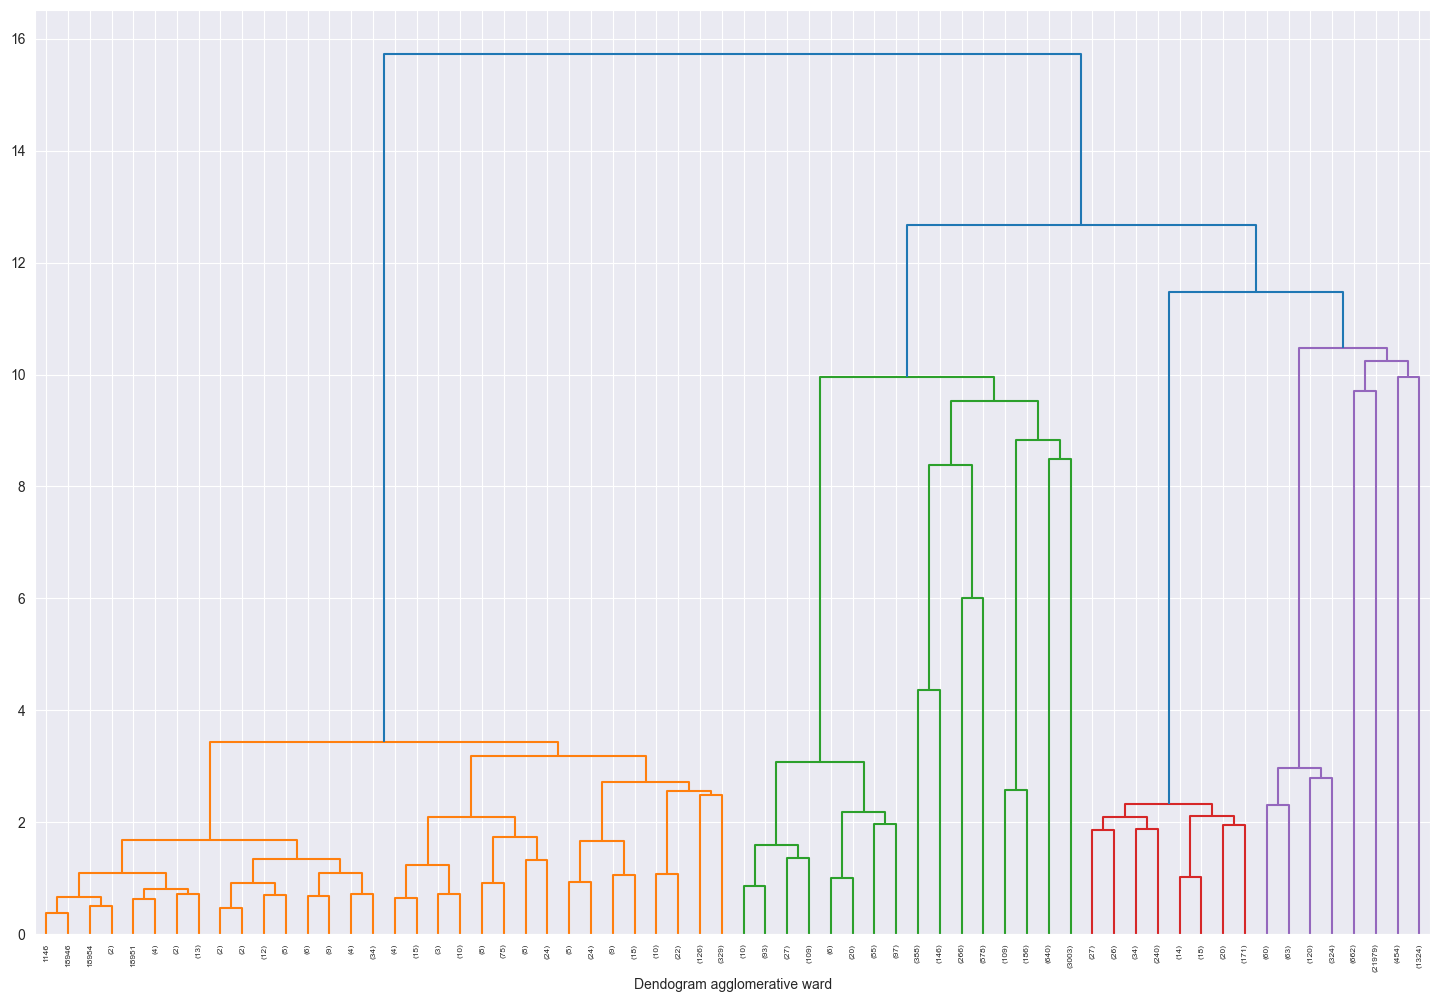

In [93]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model.fit(vec_matrix_tsvd)
plt.figure(figsize=(18, 12))
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel('Dendogram agglomerative ward')
plt.show()

## Agglomerative (complete)

In [94]:
clst_agg_avg = AgglomerativeClustering(n_clusters=10, linkage='complete')
clst_agg_avg.fit(vec_matrix_tsvd)

AgglomerativeClustering(linkage='complete', n_clusters=10)

In [95]:
data['label'] = clst_agg_avg.labels_
data

,title,pubDate,guid,link,description,combined,combined_cleaned,combined_polarity,label
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vow punish russian atro...,-0.250000,0
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war ukraine taking cover town attack jeremy bo...,0.000000,0
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic global food one world...,-0.100000,0
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...,-0.075000,6
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soar highest level ...,0.250000,0
...,...,...,...,...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...,Bell leads England to ODI clean sweep over New...,bell lead england odi clean sweep new zealand ...,0.359848,0
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...,Murrays and all-British battles headline day f...,murray allbritish battle headline day four and...,-0.035714,0
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...,Highlights: Raducanu dominant in win over Mert...,highlight raducanu dominant win mertens emma r...,0.200000,0
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...,Chasing the 'Ghost' - a superstar struck down ...,chasing ghost superstar struck lightning john ...,0.000000,0


In [96]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

label
0    0.874540
2    0.049161
4    0.017000
6    0.014942
8    0.011666
9    0.010731
1    0.008048
3    0.007798
5    0.005989
7    0.000125
Name: count, dtype: float64

In [97]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

,word,tfidf,label
0,atrocity,0.692562,0
1,flee,0.553198,0
2,food,0.722050,0
3,price,0.614070,0
4,oligarch,0.634228,0
...,...,...,...
199,emma,0.718731,3
0,one,1.000000,7
1,one,1.000000,7
2,one,1.000000,7


In [98]:
viz_data.to_csv('./Data/combined-agg-complete-clusters.csv', index=False)

In [99]:
visualize_clusters(viz_data)

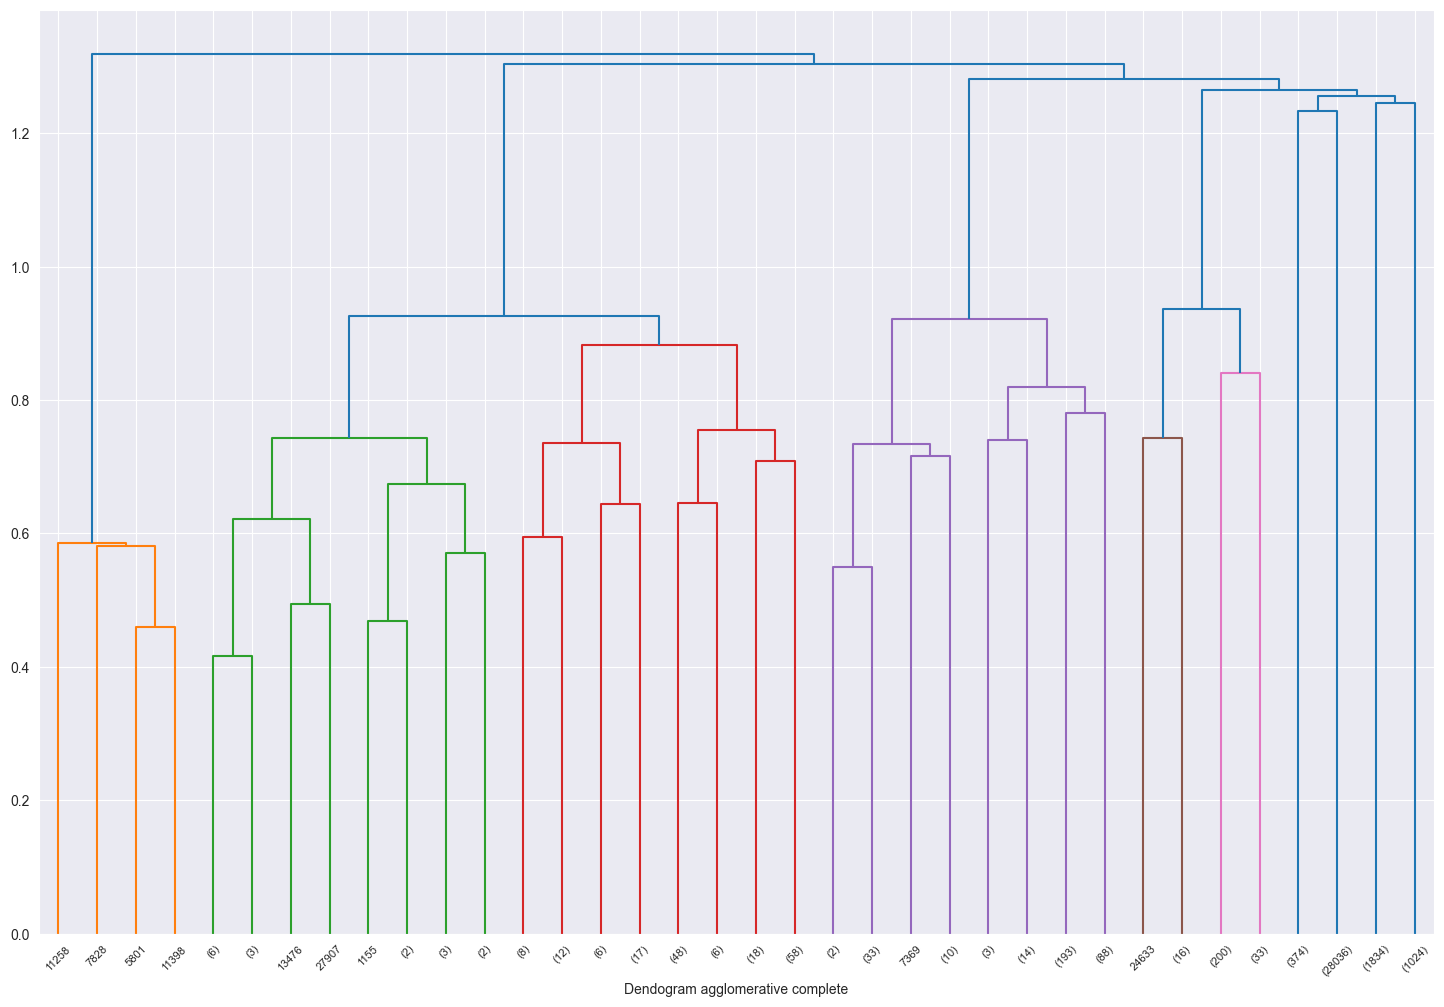

In [100]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
model.fit(vec_matrix_tsvd)
plt.figure(figsize=(18, 12))
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel('Dendogram agglomerative complete')
plt.show()

## DBSCAN

In [101]:
dbscan = DBSCAN(eps=0.5)
dbscan.fit(vec_matrix_tsvd)

DBSCAN()

In [102]:
data['label'] = dbscan.labels_
data

,title,pubDate,guid,link,description,combined,combined_cleaned,combined_polarity,label
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vow punish russian atro...,-0.250000,0
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war ukraine taking cover town attack jeremy bo...,0.000000,0
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic global food one world...,-0.100000,0
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...,-0.075000,0
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soar highest level ...,0.250000,0
...,...,...,...,...,...,...,...,...,...
32053,Bell leads England to ODI clean sweep over New...,2024-07-03 20:08:56,https://www.bbc.com/sport/cricket/articles/clk...,https://www.bbc.com/sport/cricket/articles/clk...,Lauren Bell takes a career-best 5-37 as Englan...,Bell leads England to ODI clean sweep over New...,bell lead england odi clean sweep new zealand ...,0.359848,0
32054,Murrays and all-British battles headline day four,2024-07-03 21:22:45,https://www.bbc.com/sport/tennis/articles/c720...,https://www.bbc.com/sport/tennis/articles/c720...,Andy Murray begins his Wimbledon farewell on T...,Murrays and all-British battles headline day f...,murray allbritish battle headline day four and...,-0.035714,0
32055,Highlights: Raducanu dominant in win over Mertens,2024-07-03 17:40:34,https://www.bbc.com/sport/tennis/videos/c51y4y...,https://www.bbc.com/sport/tennis/videos/c51y4y...,Emma Raducanu completes a dominant 6-1 6-2 vic...,Highlights: Raducanu dominant in win over Mert...,highlight raducanu dominant win mertens emma r...,0.200000,0
32056,Chasing the 'Ghost' - a superstar struck down ...,2024-07-03 23:03:58,https://www.bbc.com/sport/football/articles/cv...,https://www.bbc.com/sport/football/articles/cv...,John White did the League and Cup Double and w...,Chasing the 'Ghost' - a superstar struck down ...,chasing ghost superstar struck lightning john ...,0.000000,0


In [103]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

label
 0    0.99816
-1    0.00184
Name: count, dtype: float64

In [104]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

,word,tfidf,label
0,atrocity,0.692562,0
1,flee,0.553198,0
2,food,0.722050,0
3,arena,0.887436,0
4,price,0.614070,0
...,...,...,...
54,immigration,0.725203,-1
55,tournament,0.578646,-1
56,fan,0.626407,-1
57,icon,0.578278,-1


In [105]:
viz_data.to_csv('./Data/combined-dbscan-clusters.csv', index=False)

In [106]:
visualize_clusters(viz_data)